## Loading pre-computed PaCMAP dimensions for the multi-tile acquisition and subsequest unmixing analysis (Figure 3)

In [1]:
# imports
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)
from functions_EDX import *

from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
import warnings
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.metrics import DistanceMetric
import tifffile as tif
import pacmap

In [2]:
### sub-routine to get file names
def get_file_paths(spectrum_folder):
    file_names = []
    tmp = os.listdir(spectrum_folder)
    for filename in tmp:
        if filename.endswith('.npz'):
            file_names.append(filename)
    
    file_names = sorted(file_names)
    files = [os.path.join(spectrum_folder,file_name) for file_name in file_names]
    return files

### Load the PaCMAP instance and necessary data
- To fully load the necessary data, load the pacmap instance (.pkl extension) using pacmap.pkl, which automatically loads the saves Annoy tree (.ann extension with the same file name in the same directory!).
- Morever, load with np.load the supplementary file (.npz extension).

In [3]:
# Load the PaCMAP instance 
reduction_model = pacmap.load('/Users/aj/Desktop/PACMAP_RESULTS/Identify2/pacpam_instance/pacmap_panc_euc_20percent_SavedTree20240209-105636')
# or '/path/to/PacMAPinstance'
embeddings = reduction_model.embedding_


In [4]:
# Check the content of the supplementary file (npz extension)
supp_file_path = '/Users/aj/Desktop/PACMAP_RESULTS/Identify2/pacpam_instance/pacmap_panc_euc_20percent_SavedTree20240209-105636.npz'
# or '/path/to/PacMAPinstance'
for k in np.load(supp_file_path, mmap_mode='r').files:
    print(k)

local_maxi
description
abundance_maps
end_members
colors
overlap_ratio


In [5]:
# Load necessary data from the supplementary file 
# No need to load 'embeddings' as they are also saved in the pacmap instance. 
local_maxi = np.load(supp_file_path)['local_maxi']
abundance_maps = np.load(supp_file_path)['abundance_maps']
abundance_maps = abundance_maps / np.max(abundance_maps) # Scale to have max coefficient = 1
end_members = np.load(supp_file_path)['end_members']
colors = np.load(supp_file_path)['colors'];   colors[0] = [0,0,0]
description = np.load(supp_file_path)['description'] 
overlap_ratio = np.load(supp_file_path)['overlap_ratio'] 

# scale the embeddings
scaler = MinMaxScaler()
embeddings = scaler.fit_transform(embeddings)

In [6]:
classes = ['Cytoplasm','Insulin','Nucleic acids','Exocrine granules','PP or Ghrelin','Glucagon',
              'Membranes','Lysosomes A','Lysosomes B','Lysosomes C','Nucleolus','Lysosomes D']
local_maxi = [(9, 97), (47, 53), (82, 46), (96, 54), (102, 56), (109, 60)
              , (124, 74), (94, 6), (56, 5), (61, 1), (90, 53), (61, 5)]

### Visualize the reduced dimension

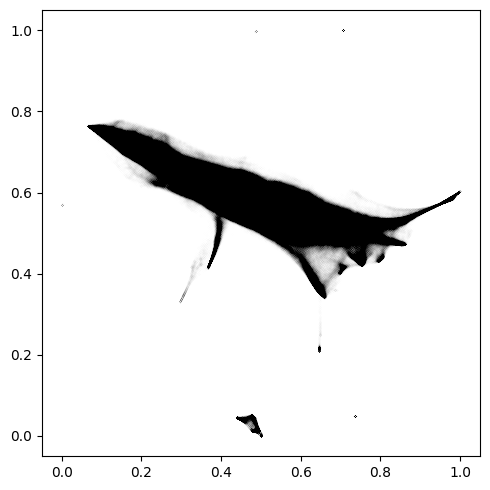

In [7]:
%matplotlib inline 
f, ax = plt.subplots(figsize=(5,5))
#sns.despine(left=True, bottom=True, right=True)
ax.set_facecolor((1, 1, 1)) 
ax.scatter(embeddings[:,0],embeddings[:,1], s=0.00001,c='k',alpha=0.5) 
f.tight_layout()
#plt.axis('off')
plt.show()

### Compute the endmembers based on the selected maxima

In [8]:
Grid = 128
xmin, xmax = np.amin(embeddings[:,0]), np.amax(embeddings[:,0])
ymin, ymax = np.amin(embeddings[:,1]), np.amax(embeddings[:,1])
counts, xedges, yedges = np.histogram2d(embeddings[:,0], embeddings[:,1], bins=Grid)

local_max_x = []
local_max_y = []
for i in range(0,len(local_maxi)):
    NewValue_X = (((local_maxi[i][0] ) * (xmax - xmin)) / (Grid - 0)) + xmin
    NewValue_Y = (((local_maxi[i][1] - 0) * (ymax - ymin)) / (Grid - 0)) + ymin
    local_max_x.append(NewValue_X)
    local_max_y.append(NewValue_Y)

x = [x for x in zip(local_max_x,local_max_y)]
nEM = len(x)

x_all = np.copy(x)
print("Number of endmembers found %03d" % nEM)

Number of endmembers found 012


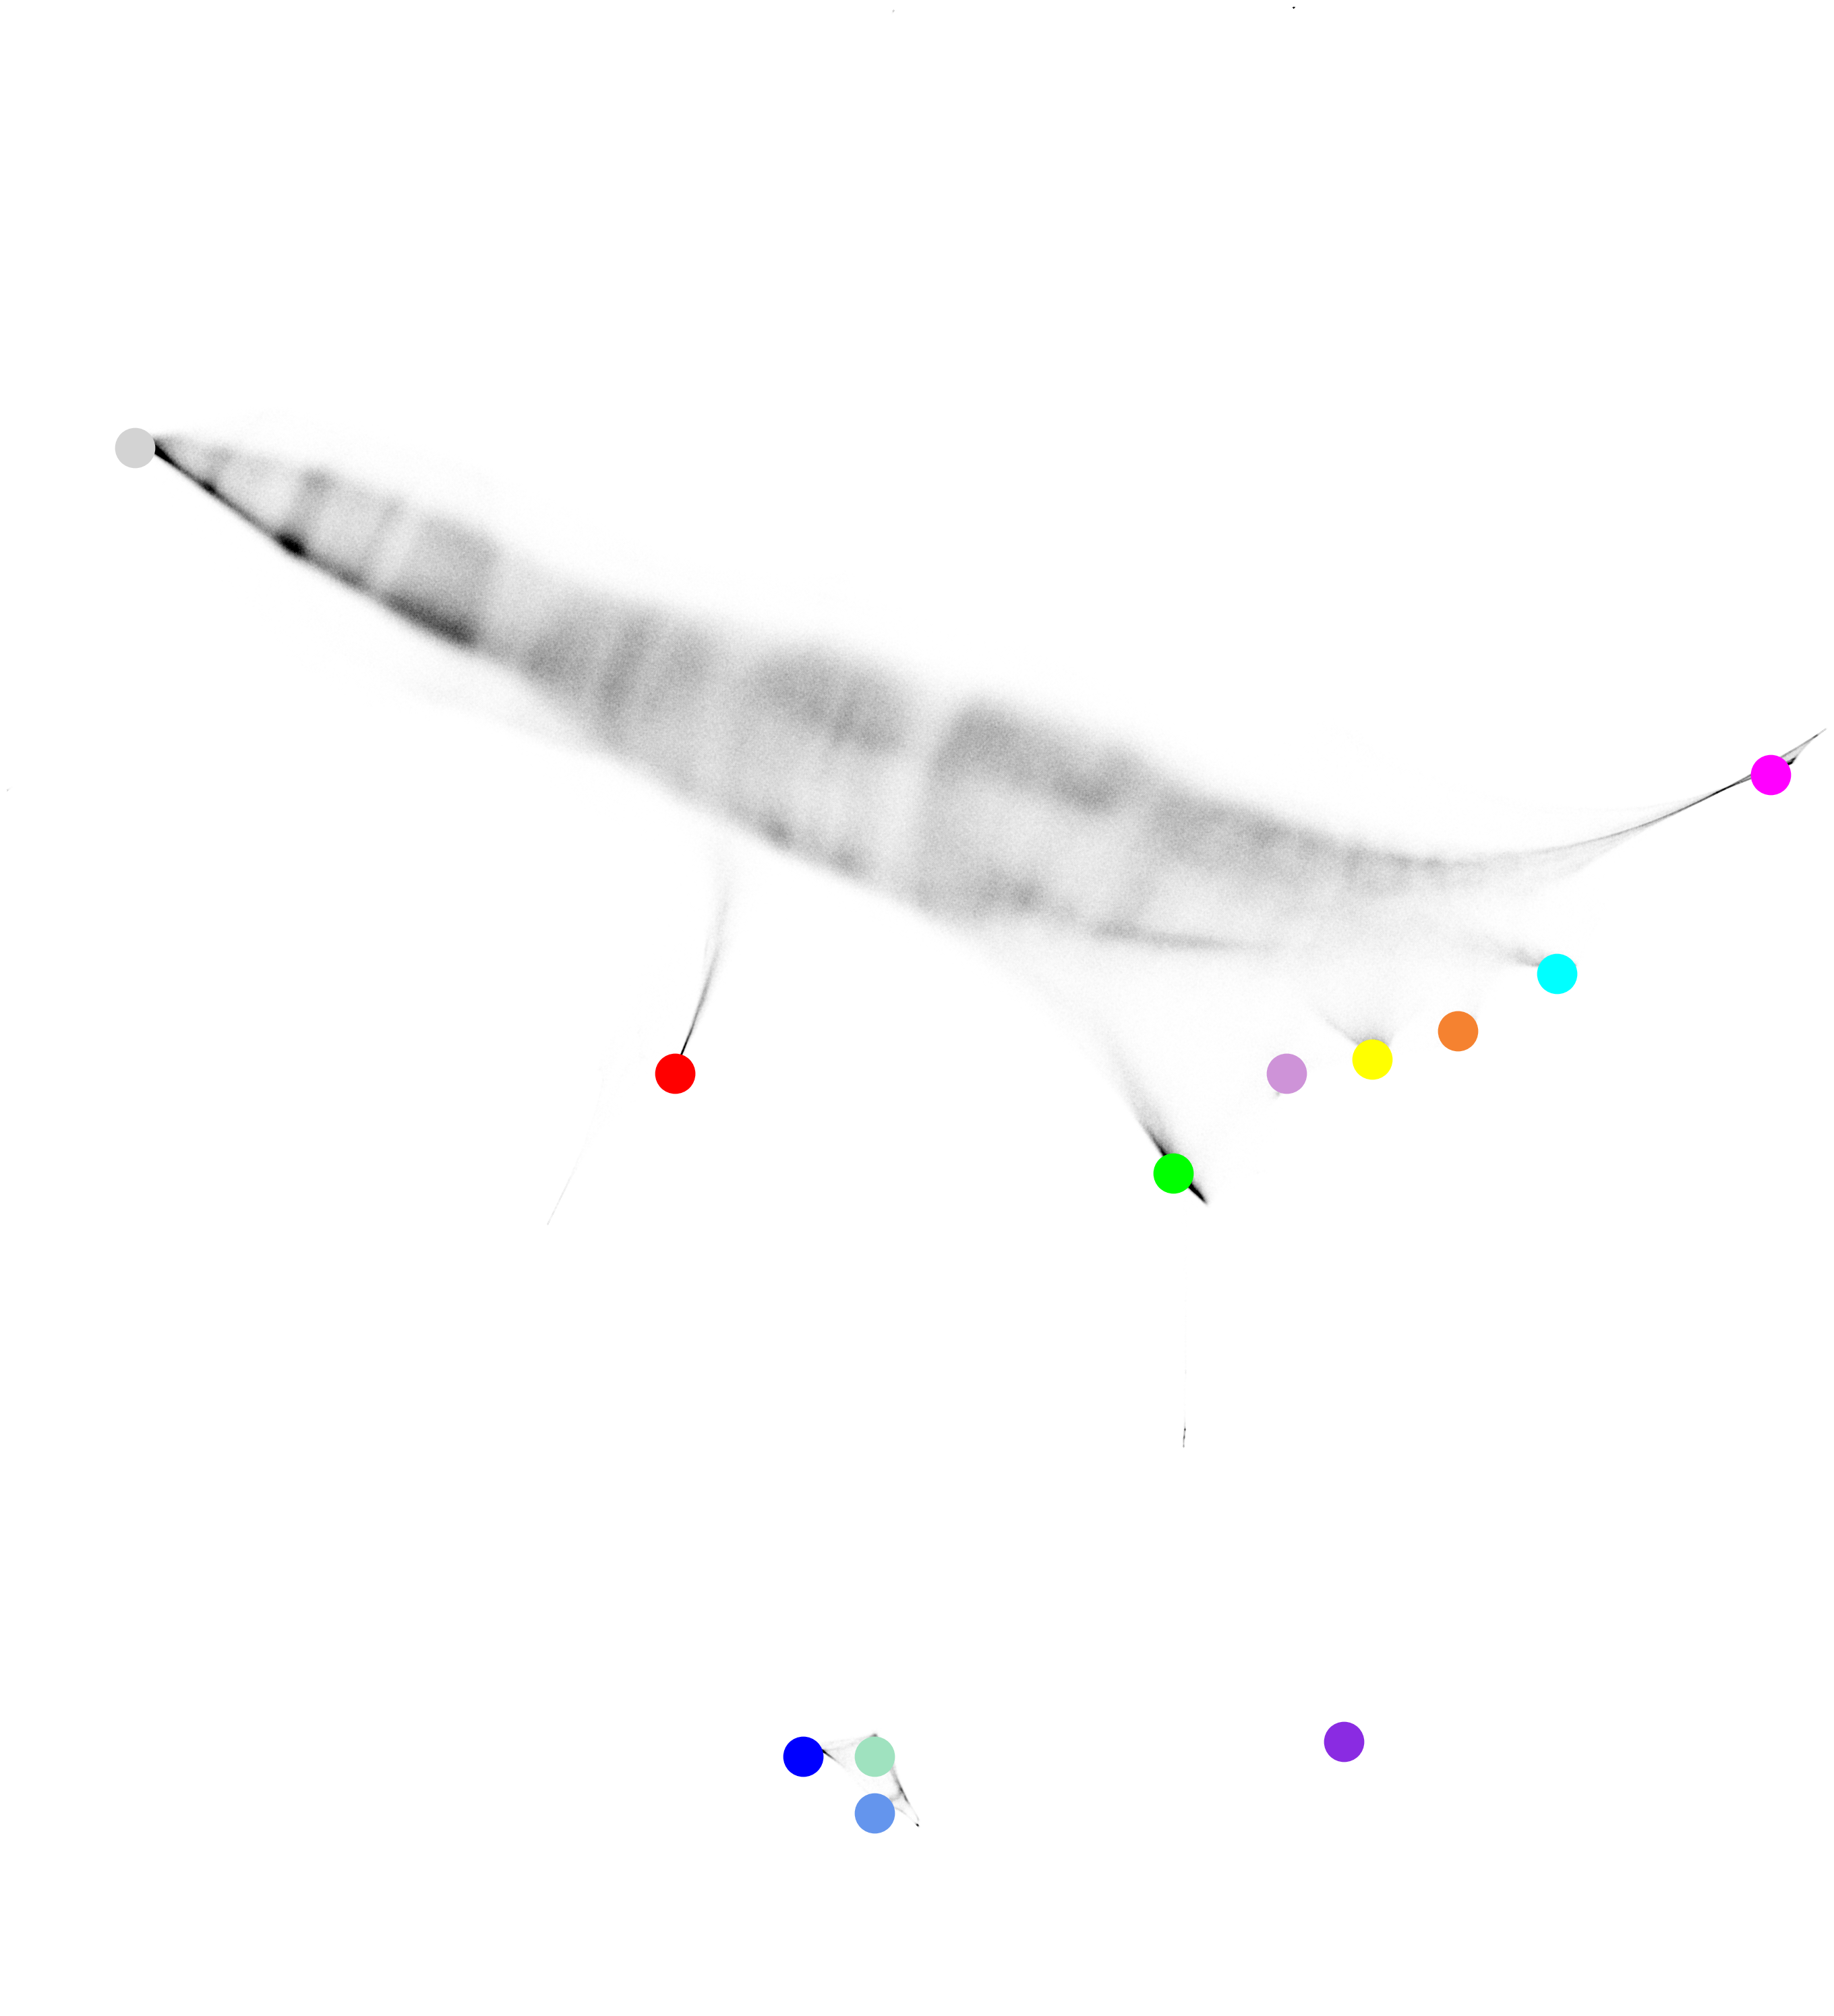

In [14]:
min_max = 1*(1/Grid) 
points = len(x)
centroid = [] 
F = [] 

for i in range(0,points):   
    #set bounding square 
    Minx = x[i][0] - min_max
    Maxx = x[i][0] + min_max
    Miny = x[i][1] - min_max
    Maxy = x[i][1] + min_max
    
    #select points
    z3 = [0 if j == 0 else j for j in [j if j <= Maxx else 0 for j in [j if j >= Minx else 0 for j in embeddings[:,0]]]]
    zz3 = [0 if j == 0 else j for j in [j if j <= Maxy else 0 for j in [j if j >= Miny else 0 for j in embeddings[:,1]]]]
    f = [i for i, e in enumerate([x*y for x,y in zip(z3,zz3)]) if e != 0]
    d = embeddings[f]
    F.append(f)
    centroid.append(d)
    
%matplotlib inline 
fig, ax = plt.subplots(figsize=(30,30))
sns.despine(left=True, bottom=True, right=True)


# Scatter plot
ax.scatter(embeddings[:,0],embeddings[:,1],c='k',s=0.00001, alpha=1)
ax.set_ylim([ymin-0.1, ymax])
ax.set_xlim([xmin, xmax])
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.set_aspect('equal')


# Endmembers annotation
label = [val for val in list(range(len(x)))]
label = classes
centroids = np.array(x).transpose()

# Show class names on the scastter plot 
#for i, txt in enumerate(label):
#    ax.annotate(txt, (centroids[0][i], centroids[1][i]), color=colors[i], size=8)

# Show the centroid locations only
for i in range(centroids.shape[1]):
    ax.plot(centroids[0][i], centroids[1][i],color = colors[i],label=classes[i],marker='o',markersize=42)    
#ax.legend()
fig.tight_layout()

# Save 
#plt.savefig(os.path.abspath(os.path.join(os.getcwd(), os.pardir,'Results','scatter_plot_maxima.png')),dpi=300)
#plt.savefig(os.path.abspath(os.path.join(os.getcwd(), os.pardir,'Results','scatter_plot_maxima.svg')))

# Prevent figure from showing
#plt.close()

### Visualize the Abundance maps

In [ ]:
# Options
cols = 5
rows = 6
cmap_abn = 'jet'
xy_res = 1024

#abundance_maps = np.reshape(abundance_maps,(np.shape(abundance_maps)[0],xy_res,xy_res,len(files)))

for ends in range(len(end_members.transpose())):
    print('Endmember %02d' % ends)
    fig, ax = plt.subplots(rows,cols,figsize=(15,15))
    tile_cnt = 0
    for i in range(rows):
        for j in range(cols):
            try:
                im_map = ax[i][j].imshow(abundance_maps[ends,:,:,tile_cnt]*~overlap_corr(tile_idx=tile_cnt,xy_dim=1024,rows=rows,cols=cols,overlap_ratio=overlap_ratio),
                                         interpolation=None,cmap=cmap_abn,vmin=0,vmax=1)
            except:
                im_map = ax[i][j].imshow(np.zeros((1024,1024)))

            try:
                ax[i][j].set_title('Tile %02d (%04d), EM %02d' % (tile_cnt,int(tile_numbers[tile_cnt]),ends))
            except:
                ax[i][j].set_title('Tile %02d, EM %02d' % (tile_cnt,ends))

            ax[i][j].axes.get_xaxis().set_visible(False)
            ax[i][j].axes.get_yaxis().set_visible(False)
            divider = make_axes_locatable(ax[i][j])
            cax = divider.append_axes('right', size='5%', pad=0.05)
            cbar = fig.colorbar(im_map, cax=cax, orientation='vertical')
            tile_cnt+=1
    plt.tight_layout()
    plt.show()

### Calculate a mosaic of the color composite image of the abundance maps

In [ ]:
paint_idx = [i for i in range(end_members.shape[1])]
cols = 5
rows = 6


# initialize and build row by row
mosaic_clem = np.zeros((1024*rows,1024*cols,3))
for j in range(rows):
    k = cols*(j+1)-cols
    tiles = [i for i in range(k,k+cols)]
    arrays = [abundance_maps[paint_idx,:,:,tile]*~overlap_corr(tile_idx=tile,xy_dim=1024,rows=rows,cols=cols,overlap_ratio=0.02) for tile in tiles]
    abundance_maps_stacked = np.dstack(arrays)   
    
    rgb_image = np.zeros((3,abundance_maps_stacked.shape[1],abundance_maps_stacked.shape[2]))
    for x in range(rgb_image.shape[1]):
        for y in range(rgb_image.shape[2]):
            idx = np.argmax(abundance_maps_stacked[:,x,y])            
            rgb_image[0,x,y] = colors[idx][0]*abundance_maps_stacked[idx,x,y] #if idx!=0 else colors[idx][0]*(1-abundance_maps_stacked[idx,x,y])
            rgb_image[1,x,y] = colors[idx][1]*abundance_maps_stacked[idx,x,y] #if idx!=0 else colors[idx][1]*(1-abundance_maps_stacked[idx,x,y])
            rgb_image[2,x,y] = colors[idx][2]*abundance_maps_stacked[idx,x,y] #if idx!=0 else colors[idx][2]*(1-abundance_maps_stacked[idx,x,y])

    mosaic_clem[1024*(j):1024*(j)+1024,:,:] = rgb_image.transpose(1,2,0) #(rgb_image.transpose(1,2,0)*255).astype('uint8')
    print(j,end='\r')

print('Completed')
 

### Visualize 

In [ ]:
fig,ax = plt.subplots(figsize=(5,10))
ax.set_axis_off()
ax.set_frame_on('False')
#ax.imshow(mosaic_clem)
ax.imshow((mosaic_clem*255).astype('uint8'))
fig.tight_layout()
plt.show()

### Save Tiles into indiviual RGB tiffs 

In [ ]:
### Save tifs for stitching
# First, get the paths to the directory containing the preprocessing data
spectrum_folder = r'path/to/Spectrum2D_extendedGauss1_3_5'
files = get_file_paths(spectrum_folder)

timestr = time.strftime("%Y%m%d-%H%M%S")
mixin = False    # If true, one endmember is replaced by HAADF pixel values (optional)
mixin_idx = 5    # The endmember that gets replaced by HAADF pixels (optional)

# directory names
folder_name = 'RGB_blackCytoplasm_inverted_' + timestr #'SomeAppropriateName_' + timestr
tiff_parent_directory = r'path/to/directory'   #'path/to/directory'
folder_path = os.path.join(tiff_parent_directory,folder_name)

try:
        os.mkdir(folder_path)
except:
        print('folder exists')


for tile in range(len(files)):
    abundance_tile = abundance_maps[paint_idx,:,:,tile]
    rgb_image = np.zeros((3,abundance_tile.shape[1],abundance_tile.shape[2]))

    # without haadf
    if not mixin:
        for x in range(rgb_image.shape[1]):
            for y in range(rgb_image.shape[2]):
                idx = np.argmax(abundance_tile[:,x,y])
                rgb_image[0,x,y] = colors[idx][0]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][0]*(1-abundance_tile[idx,x,y])
                rgb_image[1,x,y] = colors[idx][1]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][1]*(1-abundance_tile[idx,x,y])
                rgb_image[2,x,y] = colors[idx][2]*abundance_tile[idx,x,y] if idx!=0 else colors[idx][2]*(1-abundance_tile[idx,x,y])
    # with haadf
    else:
        haadf = np.load(files_npz[tile])['haadf']
        haadf = normalize8(rebin_XY(haadf))
        haadf = np.stack((haadf,)*3, axis=-1)
        for x in range(rgb_image.shape[1]):
            for y in range(rgb_image.shape[2]):
                idx = np.argmax(abundance_tile[:,x,y])
                # select a condition for mixing in the HAADF
                if idx == mixin_idx:            
                    rgb_image[:,x,y] = haadf.transpose(2,0,1)[:,x,y]
                else:
                    rgb_image[0,x,y] = colors[idx][0] * abundance_tile[idx,x,y] 
                    rgb_image[1,x,y] = colors[idx][1] * abundance_tile[idx,x,y]
                    rgb_image[2,x,y] = colors[idx][2] * abundance_tile[idx,x,y]
    
    tif.imwrite(os.path.join(folder_path,'Tile_%02d.tiff' % tile),(rgb_image.transpose(1,2,0)*255).astype('uint8'))
    print(tile,end='\r')
    

### Save individual Tiles into individual tiffs

In [ ]:
# First, get the paths to the directory containing the preprocessing data
spectrum_folder = r'path/to/Spectrum2D_extendedGauss1_3_5'
files = get_file_paths(spectrum_folder)

# directory names
timestr = time.strftime("%Y%m%d-%H%M%S")
folder_name = 'abundancemaps_' + timestr #'SomeAppropriateName_' + timestr
tiff_parent_directory = r'path/to/directory'   #'path/to/directory'
folder_path = os.path.join(tiff_parent_directory,folder_name)

try:
        os.mkdir(folder_path)
except:
        print('folder exists')

for EM_idx in range(abundance_maps.shape[0]):
    subfolderpath = os.path.join(folder_path,'%02d' % EM_idx)
    os.mkdir(subfolderpath)
    
    for tile in range(len(files)):
        abundance_tile = abundance_maps[EM_idx,:,:,tile]
        tif.imwrite(os.path.join(subfolderpath,'Tile_%02d.tiff' % tile),(abundance_tile*255).astype('uint8'))
        print(tile,end='\r')
    

### Reconstruction and error (~20 minutes)
- Compute the reconstruction and errors to visualize them (optional).

In [ ]:
# First, get the paths to the directory containing the preprocessing data
spectrum_folder = r'path/to/Spectrum2D_extendedGauss1_3_5'
files = get_file_paths(spectrum_folder)

In [ ]:
error_maps = np.zeros((1024,1024,len(files)))

for j,tile_path in enumerate(files):
    start = datetime.now()
    # load the spectrum
    spectrum_2D_tile = np.load(tile_path)['spectrum_2D'][:,:250]

    # the reconstruction
    recon_spectrum = np.dot(end_members,abundance_maps[:,:,:,j].reshape((-1,1024**2)))

    # square error of the spectrum    
    SE_spectrum = np.square(spectrum_2D_tile - recon_spectrum.transpose())

    # MSE and the RMSE
    MSE = np.mean(SE_spectrum)
    RMSE = np.sqrt(MSE)
    print('MSE and RMSE for the tile:',RMSE,MSE,end='\r')

    # the mean SE per pixel
    error_maps[:,:,j] = SE_spectrum.mean(axis=1).reshape((1024,1024))
    print('Tile %02d' % j,'time to load,reconstruct and compute error: {}'.format(datetime.now() - start),end='\r')

### Scatter plot variations

In [24]:
# Compute the colors
subsample_size = int(0.20*1024**2)
colors_list = np.zeros((subsample_size*abundance_maps.shape[3],4))   #RGBA
SE_subsample = np.zeros((subsample_size*abundance_maps.shape[3]))
max_abundane_subsample = np.zeros((subsample_size*abundance_maps.shape[3]))


for tile_idx in range(abundance_maps.shape[3]):
    print(tile_idx,end='\r')
    # Random samplen overlap exclusion
    overlap_mask = overlap_corr(tile_idx=tile_idx,xy_dim=1024,rows=6,cols=5,overlap_ratio=overlap_ratio).ravel()
    non_overlap_indices = np.asarray([i for i in range(1024**2)])[~overlap_mask]
    np.random.seed(0); sample = np.random.choice(non_overlap_indices, subsample_size)
    
    # Color
    max_color_tile = np.argmax(abundance_maps[:,:,:,tile_idx],axis=0)
    alpha_tile = np.max(abundance_maps[:,:,:,tile_idx],axis=0)
    
    # Reshape
    max_color_tile = max_color_tile.reshape((1024**2))
    alpha_tile = alpha_tile.reshape(((1024**2)))
    
    # Set RGB then A
    colors_list[tile_idx*subsample_size:(tile_idx+1)*subsample_size,:3] = [colors[i] for i in max_color_tile[sample]]
    colors_list[tile_idx*subsample_size:(tile_idx+1)*subsample_size,3] = [alpha_tile[i] for i in max_color_tile[sample]]

    # Max abundance subsample
    max_abundane_subsample[tile_idx*subsample_size:(tile_idx+1)*subsample_size] = np.max(abundance_maps[:,:,:,tile_idx],axis=0).reshape(((1024**2)))[sample]
    
    # Error maps subsample  
    #SE_subsample[tile_idx*subsample_size:(tile_idx+1)*subsample_size] = error_maps[:,:,tile_idx].reshape(((1024**2)))[sample]
print('Done')

Done


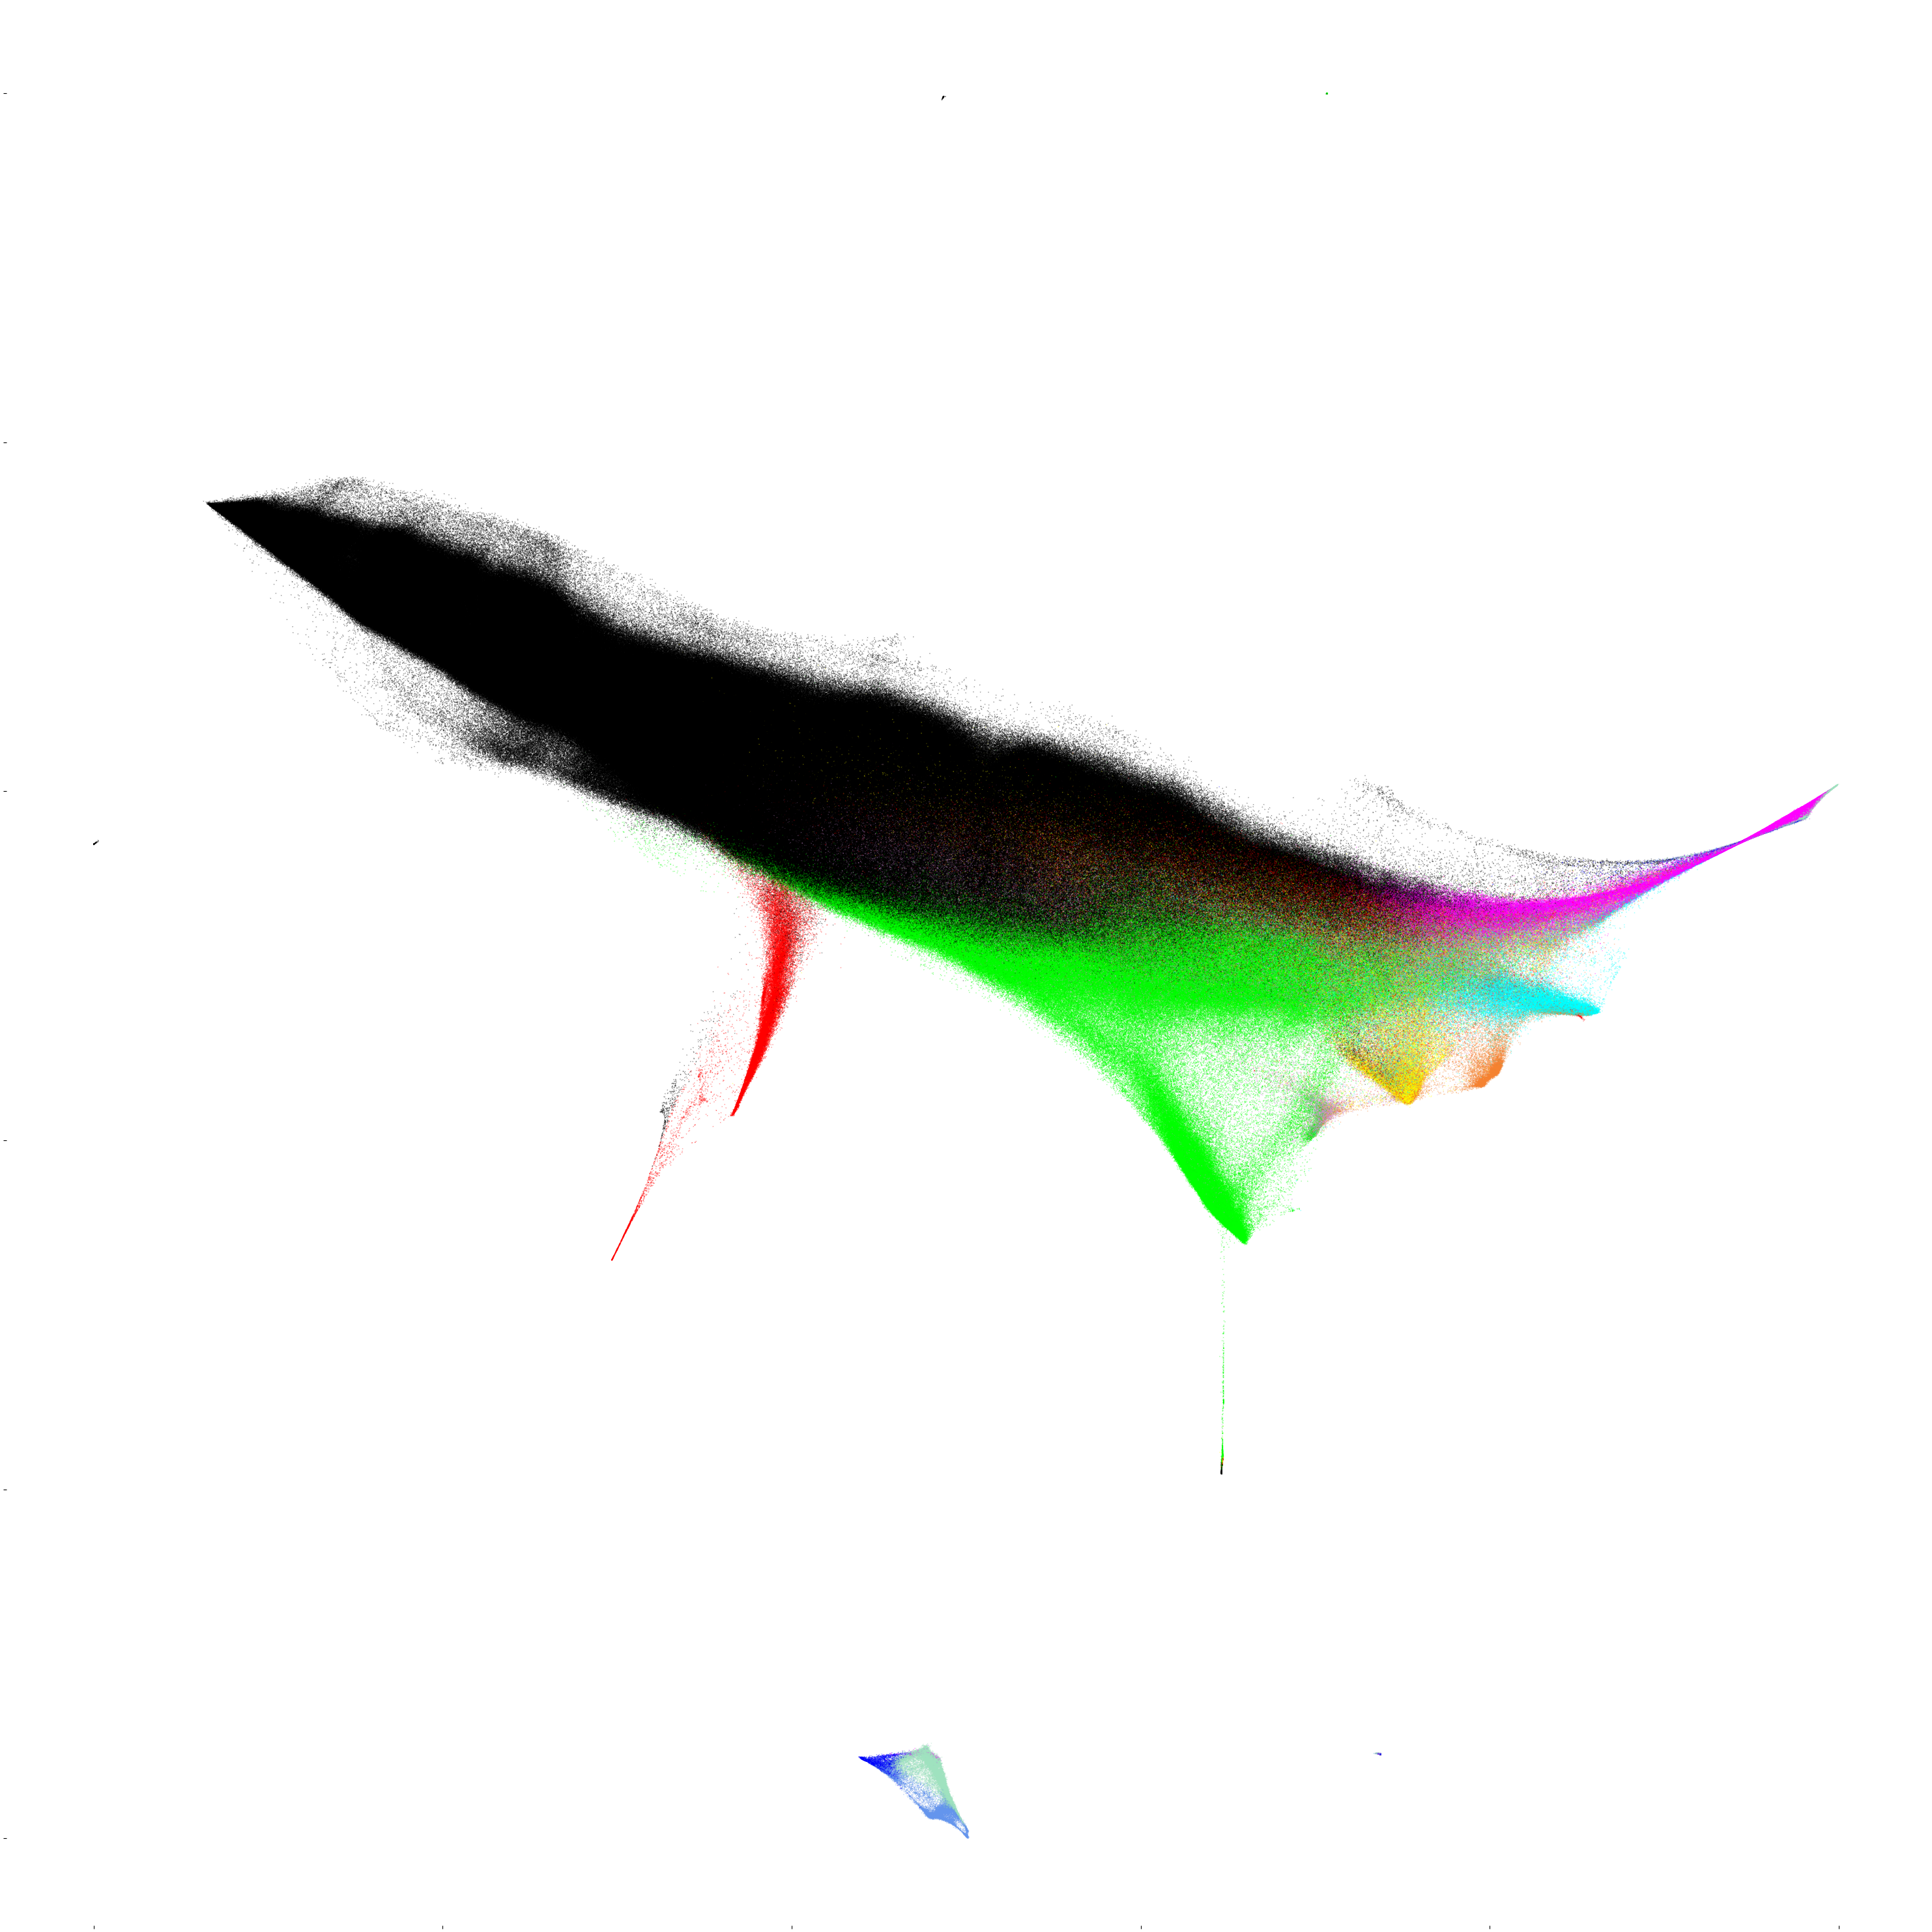

In [28]:
# Visualize 
%matplotlib inline 

# Select a mode (comment the others)
mode = 'color'  
#mode = 'max_abundance'
#mode = 'error'   


# ajust the colormap for max_abundance
from matplotlib.colors import LinearSegmentedColormap
twilight_shifted = plt.get_cmap('twilight_shifted')
custom_cmap_twshifted = LinearSegmentedColormap.from_list("twilight_half", twilight_shifted(np.linspace(0.5, 1, 256)))


# Figure
f, ax = plt.subplots(figsize=(30,30))
sns.despine(left=True, bottom=True, right=True)

if mode == 'max_abundance':
    scatter_im = ax.scatter(embeddings[:,0],embeddings[:,1], s=0.01,c=MinMaxScaler().fit_transform(max_abundane_subsample.reshape(-1, 1)),cmap=custom_cmap_twshifted ,marker='x') 
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    #plt.colorbar(scatter_im, ax=ax, orientation='horizontal')

elif mode == 'color':
    ax.scatter(embeddings[:,0],embeddings[:,1], s=0.01,c=colors_list[:,:3],marker='x')

elif mode == 'error':
    scatter_im = ax.scatter(embeddings[:,0],embeddings[:,1], s=0.01,c=MinMaxScaler().fit_transform(SE_subsample.reshape(-1, 1)),cmap='jet',marker='x') 
    #cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(scatter_im, ax=ax, orientation='horizontal')

ax.set_aspect('equal')
ax.set_facecolor('white')
f.tight_layout() 
#plt.axis('off')
ax.xaxis.set_tick_params(labelbottom=False)
ax.yaxis.set_tick_params(labelleft=False)


plt.savefig(os.path.abspath(os.path.join(os.getcwd(), os.pardir,'Results','scatter_plot_%s.png' % mode)),dpi=300)
#plt.close()


#### save custom colorbar separately

In [ ]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
f, ax = plt.subplots(figsize=(1,0.05))
ax.imshow(gradient, aspect='auto', cmap=custom_cmap_twshifted)
ax.set_axis_off()
plt.savefig(os.path.abspath(os.path.join(os.getcwd(), os.pardir,'Results','custom_cbar.svg')))
plt.show()

### Heatmap endmember visualization

In [ ]:
import exspy as xs

# define elements to plot, their x-ray lines and find the respective energy (in keV)
xray_lines = [['C', 'Ka'],['N', 'Ka'],['O', 'Ka'],['P', 'Ka'],['S', 'Ka'],['Cl', 'Ka'],['Ca', 'Ka'],['Cu', 'Ka'],
              ['Cu', 'La'],['Al', 'Ka'],['Fe', 'Ka'],['Fe', 'La'],['Os', 'Ma'],['Os', 'La'],['Nd','La']]

for idx, xray in enumerate(xray_lines):
    xray_lines[idx].append(xs.misc.elements.elements[xray[0]]['Atomic_properties']['Xray_lines'][xray[1]]['energy (keV)'])

#### Load spectra in all tiles to compute the mean and standard deviation that are used in the heatmap

In [ ]:
subsample_size = int(0.20*1024**2)

# intialize the array
spectrum_2D = np.zeros((subsample_size*len(files),250))

# load the preprocessed data of each file and subsample from it 
# Note: this is the subsample used to train the PaCMAP instance
for tile_idx in range(len(files)):  
    # random samplen with crop
    overlap_mask = overlap_corr(tile_idx=tile_idx,xy_dim=1024,rows=5,cols=4,overlap_ratio=overlap_ratio).ravel()
    non_overlap_indices = np.asarray([i for i in range(1024**2)])[~overlap_mask]
    np.random.seed(0); sample = np.random.choice(non_overlap_indices, subsample_size)
    spectrum_2D[tile_idx*subsample_size:(tile_idx+1)*subsample_size,:] =  np.load(files[tile_idx])['spectrum_2D'][sample,:250]
    print(tile_idx,end='\r')

#np.savez_compressed('../precomputed/mean_std_spectrum.npz',mean_spectrum=mean_spectrum,std_spectrum=std_spectrum)

In [ ]:
#import hyperspy.api as hs
file_path = r'/path/to/AnyTileDataset.npz'
# or /path/to/AnyTileDataset.npz
xray_energies = np.load(file_path)['xray_energies'][96:]
xray_energies = rebin_energies(xray_energies,250)
mean_spectrum = np.load('../precomputed/mean_std_spectrum.npz')['mean_spectrum']  #spectrum_2D.mean(axis=0) #if the above cell is computed, else load from precomputed
std_spectrum =  np.load('../precomputed/mean_std_spectrum.npz')['std_spectrum']   #spectrum_2D.std(axis=0)  #if the above cell is computed, else load from precomputed
print('Completed')

In [ ]:
# generate heatmap of selected endmembers
cmap_heatmap = 'twilight_shifted' 
vis_type = 2
vis_type_names = ['Difference','Ratio','z-score','decarbonated','MaxAbs']

xlim = 10    # limited energy (keV) axis
indices = [i for i in range(end_members.shape[1])]

# change index order
indices = [0,2,10,3,4,1,5,6,7,8,9,11]
colors_hm = [colors[i] for i in indices]
classes_hm = [classes[i] for i in indices]

# calculate the deviation of the selected endmember spectra from the average spectrum
endmember_spectra_dev = np.copy(end_members[:,indices])


for i in range(endmember_spectra_dev.shape[1]):
    if vis_type == 0:
        endmember_spectra_dev[:,i] = endmember_spectra_dev[:,i] - mean_spectrum
    elif vis_type == 1:
        endmember_spectra_dev[:,i] = np.divide(endmember_spectra_dev[:,i] , mean_spectrum)
    elif vis_type == 2:
        endmember_spectra_dev[:,i] = np.divide((endmember_spectra_dev[:,i] - mean_spectrum),std_spectrum)
    elif vis_type == 3:
        endmember_spectra_dev[:,i] = np.divide((endmember_spectra_dev[:,i] - mean_spectrum),(mean_spectrum[3]*np.ones(250)-mean_spectrum))
    elif vis_type == 4:
        endmember_spectra_dev[:,i] = np.divide(endmember_spectra_dev[:,i] , max_spectrum)

print('Check: ',endmember_spectra_dev.min(),endmember_spectra_dev.max())

f, ax = plt.subplots(figsize = (20,5))
dyn_range = np.sqrt(np.max(endmember_spectra_dev * endmember_spectra_dev))


if vis_type == 1:
    divnorm = clrs.TwoSlopeNorm(vmin=0, vcenter=1, vmax=dyn_range) # normalize cmap, re-centered

    hm = ax.imshow(np.transpose(endmember_spectra_dev[0:np.argmin(np.abs(xray_energies-xlim)),:]), 
          cmap = cmap_heatmap,
          norm = divnorm,    # vmin/vmax deleted, normalization added
          aspect = 'auto',
          origin = 'lower')
else:
    hm = ax.imshow(np.transpose(endmember_spectra_dev[0:np.argmin(np.abs(xray_energies-xlim)),:]), 
              cmap = cmap_heatmap, 
              vmin = dyn_range*-1, 
              vmax = dyn_range, 
              aspect = 'auto',
              origin = 'lower')
# set yticks
yticks = []
ylabels = [] 
for idx in range(endmember_spectra_dev.shape[1]):
    yticks.append(idx)
    ylabels.append(classes_hm[idx].center(20))
ax.set_yticks(yticks, ylabels, size = 10,c='k')


# add bbox to yticks 
for idx in range(endmember_spectra_dev.shape[1]):
    ax.get_yticklabels()[idx].set_bbox(dict(boxstyle = 'round', facecolor = colors_hm[idx]))


# set xticks and add vertical lines at selected xray_lines
xticks = []
xlabels = []

# for every selected x-ray, check if below the x-limit, proceed to add as tick and vline
for xray in xray_lines:
    if xray[2] <= xlim:
        xticks.append(np.argmin(np.abs(xray_energies-xray[2])))
        if xray[1] == 'Ka':
            xlabels.append(xray[0])
        else:
            xlabels.append(xray[0] + ' ' + xray[1])
        plt.vlines(np.argmin(np.abs(xray_energies-xray[2])),
                   -0.5, 
                   endmember_spectra_dev.shape[1]-0.5, 
                   linestyle = (0,(5,10)), 
                   color = [0.1, 0.1, 0.1, 0.25], 
                   linewidth = 1)
ax.set_xticks(xticks, xlabels, rotation = 90, size = 7)
ax.set_xlabel('Energy ( 0 - ' + str(xlim) + ' keV)')

plt.tick_params(axis='y', which='both', left=False, right=False)
plt.colorbar(hm, location = 'right')
plt.title(vis_type_names[vis_type])
plt.savefig('../Results/heatmap.svg')
plt.show()
